In [1]:
!pip install torch torchaudio torchvision
!pip install librosa matplotlib numpy pandas scikit-learn tqdm


In [2]:
from google.colab import files
uploaded = files.upload()


Saving archive (3).zip to archive (3).zip
Saving archive (2).zip to archive (2).zip
Saving archive (1).zip to archive (1).zip


In [3]:
import zipfile
import os

zip_files = [
    "/content/archive (1).zip",
    "/content/archive (2).zip",
    "/content/archive (3).zip"
]

for zip_path in zip_files:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/data")

print("Datasets extracted.")


Datasets extracted.


In [4]:
import os
import pandas as pd

data_dir = "/content/data"

file_paths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav") or file.endswith(".mp3"):
            label = os.path.basename(root)
            file_paths.append(os.path.join(root, file))
            labels.append(label)

df = pd.DataFrame({"path": file_paths, "label": labels})
print(df["label"].value_counts())


label
hungry        764
discomfort    165
tired         160
burping       126
belly pain    124
laugh         108
silence       108
cold_hot      107
scared         20
belly_pain     16
lonely         11
Name: count, dtype: int64


In [5]:
label_map = {
    "belly_Pain": "belly_pain",
    "cold_hot": "cold_hot",
    "Cold/Hot": "cold_hot",
    "noise": "noise",
    "silence": "silence",
    "laugh": "laugh"
}

df["label"] = df["label"].replace(label_map)


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["encoded"] = le.fit_transform(df["label"])

print(le.classes_)


['belly pain' 'belly_pain' 'burping' 'cold_hot' 'discomfort' 'hungry'
 'laugh' 'lonely' 'scared' 'silence' 'tired']


In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["encoded"])


In [8]:
import torch
import torchaudio
from torch.utils.data import Dataset

class CryDataset(Dataset):
    def __init__(self, dataframe, duration=4):
        self.df = dataframe
        self.target_sr = 16000
        self.duration = duration
        self.num_samples = self.target_sr * self.duration

        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.target_sr,
            n_mels=64  # reduce from 128 to avoid warning
        )

        self.db_transform = torchaudio.transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]["path"]
        label = self.df.iloc[idx]["encoded"]

        waveform, sr = torchaudio.load(path)

        # Convert to mono
        waveform = waveform.mean(dim=0, keepdim=True)

        # Resample
        if sr != self.target_sr:
            resampler = torchaudio.transforms.Resample(sr, self.target_sr)
            waveform = resampler(waveform)

        # Trim or pad
        if waveform.shape[1] > self.num_samples:
            waveform = waveform[:, :self.num_samples]
        else:
            padding = self.num_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Create mel spectrogram
        mel = self.mel_transform(waveform)
        mel = self.db_transform(mel)

        return mel, label


In [9]:
from torch.utils.data import DataLoader

train_dataset = CryDataset(train_df)
val_dataset = CryDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [10]:
import torchvision.models as models
import torch.nn as nn

num_classes = len(le.classes_)

model = models.efficientnet_b0(pretrained=True)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 66.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
       

In [11]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

for epoch in range(50):
    model.train()
    total_loss = 0

    for mel, label in tqdm(train_loader):
        mel, label = mel.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


100%|██████████| 86/86 [00:24<00:00,  3.45it/s]


Epoch 1, Loss: 1.586472440597623


100%|██████████| 86/86 [00:22<00:00,  3.86it/s]


Epoch 2, Loss: 1.2190436242624771


100%|██████████| 86/86 [00:23<00:00,  3.65it/s]


Epoch 3, Loss: 1.1083407973827317


100%|██████████| 86/86 [00:21<00:00,  3.96it/s]


Epoch 4, Loss: 1.0409935962322145


100%|██████████| 86/86 [00:22<00:00,  3.84it/s]


Epoch 5, Loss: 0.9723597730315009


100%|██████████| 86/86 [00:22<00:00,  3.85it/s]


Epoch 6, Loss: 0.903167802927106


100%|██████████| 86/86 [00:22<00:00,  3.78it/s]


Epoch 7, Loss: 0.8664345533348793


100%|██████████| 86/86 [00:23<00:00,  3.69it/s]


Epoch 8, Loss: 0.8242098030655883


100%|██████████| 86/86 [00:22<00:00,  3.83it/s]


Epoch 9, Loss: 0.7876004188559776


100%|██████████| 86/86 [00:22<00:00,  3.84it/s]


Epoch 10, Loss: 0.7477226936539938


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch 11, Loss: 0.740698350376861


100%|██████████| 86/86 [00:22<00:00,  3.79it/s]


Epoch 12, Loss: 0.7133613703555839


100%|██████████| 86/86 [00:22<00:00,  3.83it/s]


Epoch 13, Loss: 0.6982148119876551


100%|██████████| 86/86 [00:23<00:00,  3.65it/s]


Epoch 14, Loss: 0.7053685593743657


100%|██████████| 86/86 [00:23<00:00,  3.70it/s]


Epoch 15, Loss: 0.6494192519160205


100%|██████████| 86/86 [00:22<00:00,  3.82it/s]


Epoch 16, Loss: 0.6622917662526286


100%|██████████| 86/86 [00:22<00:00,  3.75it/s]


Epoch 17, Loss: 0.6447513547054556


100%|██████████| 86/86 [00:27<00:00,  3.16it/s]


Epoch 18, Loss: 0.6308475299630054


100%|██████████| 86/86 [00:22<00:00,  3.80it/s]


Epoch 19, Loss: 0.6114608874154646


100%|██████████| 86/86 [00:24<00:00,  3.53it/s]


Epoch 20, Loss: 0.6120849248281744


100%|██████████| 86/86 [00:23<00:00,  3.73it/s]


Epoch 21, Loss: 0.6187751067932262


100%|██████████| 86/86 [00:23<00:00,  3.74it/s]


Epoch 22, Loss: 0.5999933075766231


100%|██████████| 86/86 [00:22<00:00,  3.80it/s]


Epoch 23, Loss: 0.5753924860510715


100%|██████████| 86/86 [00:23<00:00,  3.72it/s]


Epoch 24, Loss: 0.6007433110891387


100%|██████████| 86/86 [00:23<00:00,  3.72it/s]


Epoch 25, Loss: 0.5794065436998079


100%|██████████| 86/86 [00:23<00:00,  3.69it/s]


Epoch 26, Loss: 0.5821278826441876


100%|██████████| 86/86 [00:23<00:00,  3.70it/s]


Epoch 27, Loss: 0.5822604769884154


100%|██████████| 86/86 [00:23<00:00,  3.66it/s]


Epoch 28, Loss: 0.5674742796393328


100%|██████████| 86/86 [00:24<00:00,  3.58it/s]


Epoch 29, Loss: 0.5728233801417573


100%|██████████| 86/86 [00:24<00:00,  3.57it/s]


Epoch 30, Loss: 0.5660390396450841


100%|██████████| 86/86 [00:24<00:00,  3.58it/s]


Epoch 31, Loss: 0.5582565880099009


100%|██████████| 86/86 [00:24<00:00,  3.53it/s]


Epoch 32, Loss: 0.5430580512728802


100%|██████████| 86/86 [00:24<00:00,  3.58it/s]


Epoch 33, Loss: 0.555296100849329


100%|██████████| 86/86 [00:23<00:00,  3.58it/s]


Epoch 34, Loss: 0.5805218701445779


100%|██████████| 86/86 [00:24<00:00,  3.55it/s]


Epoch 35, Loss: 0.5655299601859824


100%|██████████| 86/86 [00:23<00:00,  3.59it/s]


Epoch 36, Loss: 0.5701671897671944


100%|██████████| 86/86 [00:24<00:00,  3.57it/s]


Epoch 37, Loss: 0.5500218313793803


100%|██████████| 86/86 [00:23<00:00,  3.58it/s]


Epoch 38, Loss: 0.5590601092161134


100%|██████████| 86/86 [00:24<00:00,  3.55it/s]


Epoch 39, Loss: 0.5571335827888444


100%|██████████| 86/86 [00:24<00:00,  3.57it/s]


Epoch 40, Loss: 0.548383031820142


100%|██████████| 86/86 [00:24<00:00,  3.57it/s]


Epoch 41, Loss: 0.521370786567067


100%|██████████| 86/86 [00:23<00:00,  3.59it/s]


Epoch 42, Loss: 0.5288469978543215


100%|██████████| 86/86 [00:23<00:00,  3.63it/s]


Epoch 43, Loss: 0.5324358704478241


100%|██████████| 86/86 [00:23<00:00,  3.67it/s]


Epoch 44, Loss: 0.5345973753651907


100%|██████████| 86/86 [00:23<00:00,  3.69it/s]


Epoch 45, Loss: 0.5342103572085847


100%|██████████| 86/86 [00:23<00:00,  3.61it/s]


Epoch 46, Loss: 0.5538652747176415


100%|██████████| 86/86 [00:23<00:00,  3.60it/s]


Epoch 47, Loss: 0.5499792965345605


100%|██████████| 86/86 [00:23<00:00,  3.59it/s]


Epoch 48, Loss: 0.5398534404677015


100%|██████████| 86/86 [00:23<00:00,  3.58it/s]


Epoch 49, Loss: 0.540133130411769


100%|██████████| 86/86 [00:24<00:00,  3.57it/s]

Epoch 50, Loss: 0.5153803357551264


In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)
        output = model(mel)
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print("Validation Accuracy:", correct / total)

Validation Accuracy: 0.7403072421360644


In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mel, label in val_loader:
        mel, label = mel.to(device), label.to(device)
        output = model(mel)
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print("Validation Accuracy:", correct / total)


Validation Accuracy: 0.543859649122807


In [14]:
import torch.nn.functional as F

def predict_cry(path):
    waveform, sr = torchaudio.load(path)
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)

    waveform = waveform.mean(dim=0)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_mels=128
    )(waveform)

    mel = torchaudio.transforms.AmplitudeToDB()(mel)
    mel = mel.unsqueeze(0).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(mel)
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    label = le.inverse_transform([pred.item()])[0]

    distress_score = int(float(conf.item()) * 100)

    return {
        "cry_type": label,
        "confidence": float(conf.item()),
        "distress_score": distress_score
    }


In [15]:
torch.save(model.state_dict(), "boop_cry_model.pth")


In [16]:
from google.colab import files
files.download("boop_cry_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import torch
torch.cuda.is_available()

True


Validation Accuracy: 74.03%
Correct Predictions: 1012/1367


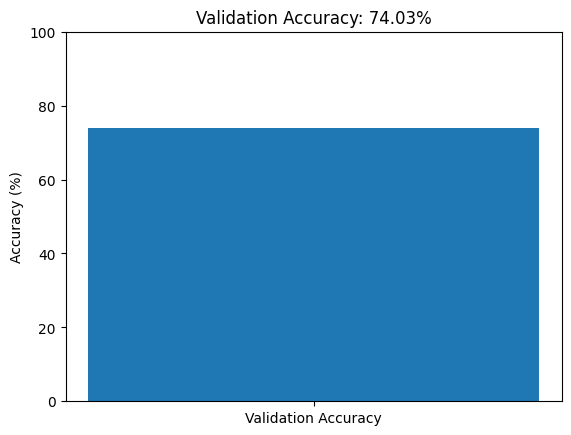

In [18]:
import matplotlib.pyplot as plt

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)
        output = model(mel)
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

# Compute accuracy
val_accuracy = correct / total
val_percentage = val_accuracy * 100

# Print nicely formatted output
print(f"\nValidation Accuracy: {val_percentage:.2f}%")
print(f"Correct Predictions: {correct}/{total}")

# Create visualization
plt.figure()
plt.bar(["Validation Accuracy"], [val_percentage])
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.title(f"Validation Accuracy: {val_percentage:.2f}%")
plt.show()